In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [2]:
data_folder = "C:/Users/bapti/ADA2024-projet/MovieSummaries/"

########### A CHANGER LE PATH DU FOLDER ##################

# 1.Datasets creation

## 1.1 Import the data

In [3]:
movie_col_name = ["Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_name",
    "Movie_release_date",
    "Movie_box_office_revenue",
    "Movie_runtime",
    "Movie_languages", # Freebase ID:name tuples
    "Movie_countries", # Freebase ID:name tuples
    "Movie_genres"] # Freebase ID:name tuples

char_col_name = ["Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_release_date",
    "Character_name",
    "Actor_date_of_birth",
    "Actor_gender",
    "Actor_height_m", # in meters
    "Actor_ethnicity", # Freebase ID
    "Actor_name",
    "Actor_age_at_movie_release",
    "Freebase_character_actor_map_ID",
    "Freebase_character_ID",
    "Freebase_actor_ID"]

In [4]:
df_movie = pd.read_csv(data_folder+'movie.metadata.tsv', delimiter = '\t', names = movie_col_name, header = None)
df_char = pd.read_csv(data_folder+'character.metadata.tsv', delimiter = '\t', names = char_col_name, header = None)

In [5]:
print("Shape of the movie dataset:", df_movie.shape)
print("Shape of the character dataset:", df_char.shape)

Shape of the movie dataset: (81741, 9)
Shape of the character dataset: (450669, 13)


## 1.2 Merging the datasets

The idea is to have all the characterisitics in one single variable

In [6]:
# We check if the two datasets have identical columns
common_col = set(movie_col_name) & set(char_col_name)
print(f"We have {len(common_col)} common columns")

We have 3 common columns


In [7]:
#We merge the two datasets
merged_df = pd.merge(df_movie, df_char, on=['Wikipedia_movie_ID', 'Freebase_movie_ID'], how='inner', suffixes=('', '_y'))
merged_df['Movie_release_date'] = merged_df['Movie_release_date'].combine_first(merged_df['Movie_release_date_y'])
merged_df.drop('Movie_release_date_y', axis =1, inplace = True, errors='ignore')

print("Shape of the merged dataset: ", merged_df.shape)
merged_df.head(5)


Shape of the merged dataset:  (450669, 19)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


## 1.3 Managing data types

As we want to work with the dates, the ages, the genders we have to make sure that the data types are the good ones

In [8]:
# Extract the first item of a dictionary
def extract_first_genre(genre_dict):
    if isinstance(genre_dict, dict):
        return next(iter(genre_dict.values()), None)
    return None

# Extract all the items of a disctionary into a list
def extract_all_genres(genre_dict):
    if isinstance(genre_dict, dict):
        # Récupère toutes les valeurs du dictionnaire
        return list(genre_dict.values())
    return None

In [9]:
# We convert the chains into dicts
merged_df['Movie_languages'] = merged_df['Movie_languages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
merged_df['Movie_countries'] = merged_df['Movie_countries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
merged_df['Movie_genres'] = merged_df['Movie_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# We create a column for the extracted first item in the list and we assume is the principal one
merged_df['Main_genre'] = merged_df['Movie_genres'].apply(extract_first_genre)
merged_df['Main_country'] = merged_df['Movie_countries'].apply(extract_first_genre)

# We replace the language, countries and genre columns by list of values
merged_df['Movie_languages'] = merged_df['Movie_languages'].apply(extract_all_genres)
merged_df['Movie_countries'] = merged_df['Movie_countries'].apply(extract_all_genres)
merged_df['Movie_genres'] = merged_df['Movie_genres'].apply(extract_all_genres)
merged_df['Movie_languages'] = merged_df['Movie_languages'].apply(lambda x: [y.replace(" Language","").replace(" languages","") for y in x])

#Convert the dates to datetime format for later calculations
merged_df['Movie_release_date'] = pd.to_datetime(merged_df['Movie_release_date'], errors='coerce').dt.normalize()
merged_df['Actor_date_of_birth'] = pd.to_datetime(merged_df['Actor_date_of_birth'], errors='coerce').dt.normalize()

In [10]:
merged_df.head(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,...,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Main_genre,Main_country
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,...,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,Thriller,United States of America
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Lieutenant Melanie Ballard,...,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,Thriller,United States of America
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Desolation Williams,...,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,Thriller,United States of America
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Sgt Jericho Butler,...,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,Thriller,United States of America
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira Kincaid,...,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,Thriller,United States of America


# 2.Study the raw data

In [11]:
merged_df.describe()

,Wikipedia_movie_ID,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Actor_date_of_birth,Actor_height_m,Actor_age_at_movie_release
count,4.506690e+05,273872,1.010280e+05,4.001990e+05,329887,154824.000000,292556.000000
mean,1.396975e+07,1986-03-21 01:35:51.124612992,6.940705e+07,1.288516e+02,1943-05-29 11:41:52.427588736,1.788893,37.788523
min,3.300000e+02,1894-11-17 00:00:00,1.000000e+04,0.000000e+00,1796-09-20 00:00:00,0.610000,-7896.000000
25%,3.759292e+06,1971-05-26 00:00:00,3.600000e+06,8.800000e+01,1922-09-01 00:00:00,1.676400,28.000000
50%,1.189065e+07,1997-04-04 00:00:00,1.784087e+07,9.700000e+01,1948-02-25 00:00:00,1.750000,36.000000
75%,2.366501e+07,2006-09-05 00:00:00,6.684503e+07,1.120000e+02,1966-07-11 00:00:00,1.830000,47.000000
max,3.750192e+07,2016-06-08 00:00:00,2.782275e+09,1.079281e+06,2011-09-02 00:00:00,510.000000,103.000000
std,1.079662e+07,NaN,1.469544e+08,5.394664e+03,NaN,4.379940,20.587870


We can observe some interesting points which seems impossible:
- Some actors have negative ages
- Some actors measure up to $510$ m high
- Some movies have a null or a million minutes runtime($\approx 1.9$ years)

# 3.Treating missing values and incoherent values

## 3.1 Filtering incoherent values

We choose to replace the impossible values by NaN because later we'll try to reconstruct the dataset

- We keep the actor ages superior or equal to 0 because some actors (babies) may be less than 1 year old so we keep their age even if it's 0.

- We keep the actor heights less than the tallest person on earth which is 2.72m.

- We keep the movie runtime superior to 1min because it is not a movie in this case. We also impose a maximum value of 51'420 minutes because according to wikipedia, the longest movie duration is $\approx 35$ days.

- We keep the movie release date superior to the actor date of birth because we don't want to have negative ages after calculations.

In [12]:
#Replace negative ages by NaN
merged_df['Actor_age_at_movie_release'] = merged_df.query('Actor_age_at_movie_release >= 0')['Actor_age_at_movie_release']
#Replace heights superior to 3 meters by NaN
merged_df['Actor_height_m'] = merged_df.query('Actor_height_m < 2.72')['Actor_height_m']
#Replace null movie runtime by NaN
merged_df['Movie_runtime'] = merged_df.query('Movie_runtime > 1')['Movie_runtime']
#Replace movie runtime superior to 35 days to NaN
merged_df['Movie_runtime'] = merged_df.query('Movie_runtime < 51420')['Movie_runtime']
#Check if there is some movies are released after the actor birth and replace both by NaN
merged_df[['Movie_release_date', 'Actor_date_of_birth']] = merged_df.query('Movie_release_date > Actor_date_of_birth')[['Movie_release_date', 'Actor_date_of_birth']]

merged_df.describe()

,Wikipedia_movie_ID,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Actor_date_of_birth,Actor_height_m,Actor_age_at_movie_release
count,4.506690e+05,205197,1.010280e+05,400163.000000,205197,154809.000000,292175.000000
mean,1.396975e+07,1983-10-11 09:52:52.309536832,6.940705e+07,101.892150,1944-05-26 05:02:33.107501568,1.748177,37.890901
min,3.300000e+02,1894-11-17 00:00:00,1.000000e+04,1.250000,1796-09-20 00:00:00,0.610000,0.000000
25%,3.759292e+06,1965-04-21 00:00:00,3.600000e+06,88.000000,1923-03-24 00:00:00,1.676400,28.000000
50%,1.189065e+07,1994-08-29 00:00:00,1.784087e+07,97.000000,1950-03-26 00:00:00,1.750000,36.000000
75%,2.366501e+07,2005-09-23 00:00:00,6.684503e+07,112.000000,1968-03-06 00:00:00,1.830000,47.000000
max,3.750192e+07,2016-06-08 00:00:00,2.782275e+09,9360.000000,2008-10-29 00:00:00,2.356000,103.000000
std,1.079662e+07,NaN,1.469544e+08,42.953552,NaN,0.106249,14.085909


## 3.2 Dataset reconstruction
With our previous manipulations, we have some missing data. For our interest categories, we want to try to reconstruct our dataset to have a more representative sample.
- The missing genders will be deduced from an additional dataset that associates first name with a gender
- The missing actors' ages will be calculated from their date of birth and the movie release date

In [13]:
# !pip install -q names_dataset #to install the dataset to reconstruct the genre

In [14]:
from names_dataset import NameDataset, NameWrapper
nd = NameDataset()

In [15]:
def split_name(full_name):
    parts = full_name.strip().split()
    
    f_name = parts[0] if parts else ''
    return f_name

In [16]:
def get_gender(name):
    f_name = split_name(name)
    temp = nd.search(f_name)

    if temp['first_name'] is not None : 
        prob_male = temp['first_name']['gender'].get('Male',0)
        prob_female = temp['first_name']['gender'].get('Female',0)

        #We use a threshold of 85% of confidence about the gender. 
        #When 85% of the time, the name considered is associated to a specific gender, 
        #we decide that this is the correct genre.
        if prob_male > 0.85:
            gender = 'M'
        elif prob_female > 0.85:
            gender ='F'
        else :
            gender = 'Unknown' #when there is a doubt on the gender, we replace it by unknown.

        return gender

In [17]:
#We reconstruct the actor gender based on his/her first name using the get_gender() function
merged_df.loc[(merged_df['Actor_gender'].isnull()) & (merged_df['Actor_name'].notnull()), 'Actor_gender'] = merged_df.loc[(merged_df['Actor_gender'].isnull()) & (merged_df['Actor_name'].notnull()), 'Actor_name'].apply(get_gender)


In [18]:
#All the actors we weren't able to reconstruct gender, we replace it by 'Unknown'
merged_df.loc[merged_df['Actor_gender'].isnull(),'Actor_gender'] = 'Unknown'

In [19]:
merged_df.loc[merged_df['Actor_gender'] == 'Unknown'].head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,...,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Main_genre,Main_country
139,31983669,/m/0g4_n3m,Road to Life,NaT,NaN,104.0,[Russian],[Soviet Union],[Drama],NaN,...,Unknown,NaN,NaN,Bozhak Besprizornykh,NaN,/m/0g4_nf9,NaN,/m/0g4_ncr,Drama,Soviet Union
140,31983669,/m/0g4_n3m,Road to Life,NaT,NaN,104.0,[Russian],[Soviet Union],[Drama],NaN,...,Unknown,NaN,NaN,Tsifan Kyriya,NaN,/m/0g4_nff,NaN,/m/0g4_ncv,Drama,Soviet Union
164,156558,/m/014k4y,Baby Boy,NaT,29381649.0,123.0,[English],[United States of America],"[Crime Fiction, Drama, Coming of age]",Já Toi,...,Unknown,NaN,NaN,Jamaica Carter,NaN,/m/03jnyf2,/m/03jnyf5,/m/03jnyff,Crime Fiction,United States of America
170,156558,/m/014k4y,Baby Boy,NaT,29381649.0,123.0,[English],[United States of America],"[Crime Fiction, Drama, Coming of age]",Mexican Neighbor,...,Unknown,NaN,NaN,Roma Alvarez,NaN,/m/03jny6m,/m/03jny6q,/m/03jny6z,Crime Fiction,United States of America
174,156558,/m/014k4y,Baby Boy,NaT,29381649.0,123.0,[English],[United States of America],"[Crime Fiction, Drama, Coming of age]",Sheryl,...,Unknown,NaN,NaN,Serese Teate,NaN,/m/03jny3h,/m/03jny3l,/m/03jny3v,Crime Fiction,United States of America


In [20]:
#We search for the number of missing actors' ages
#We also check if the actor's age can be calculated knowing the movie release date and the actor's date of birth
age_mask = (merged_df['Actor_age_at_movie_release'].isnull()) & (merged_df['Movie_release_date'].notnull()) & (merged_df['Actor_date_of_birth'].notnull())
count_age_incomplete  = merged_df[age_mask].shape[0]
print(f"We have {count_age_incomplete} missing actors' ages that can be calculated")

We have 21031 missing actors' ages that can be calculated


In [21]:
#We compute the actors' ages
merged_df.loc[age_mask,'Actor_age_at_movie_release'] = (merged_df['Movie_release_date'] - merged_df['Actor_date_of_birth']).dt.days // 365
#We replace the ages superior to 115 by NaN
merged_df['Actor_age_at_movie_release'] = merged_df.query('Actor_age_at_movie_release < 115')['Actor_age_at_movie_release']

#Now, we only want to keep the years of the release date
merged_df['Movie_release_date'] = merged_df['Movie_release_date'].dt.year

## 3.3 Analysis of the missing values after data reconstruction

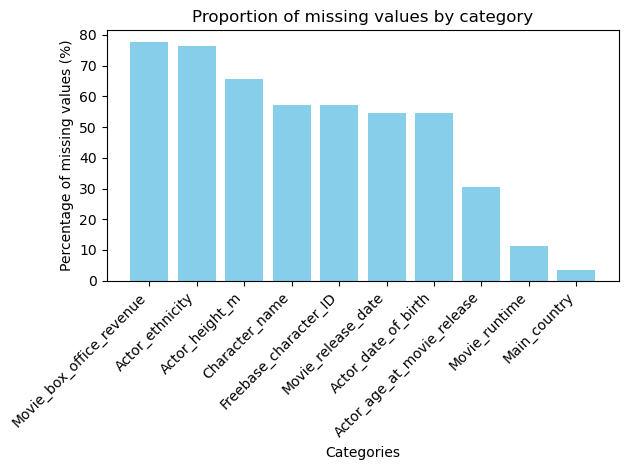

In [22]:
proportion_of_null = merged_df.isnull().mean()*100
proportion_of_null = proportion_of_null[proportion_of_null>1] #only missing at least 1% of value
proportion_of_null = proportion_of_null.sort_values(ascending=False)

plt.bar(proportion_of_null.index, proportion_of_null.values, color='skyblue')
plt.title('Proportion of missing values by category')
plt.xlabel('Categories')
plt.ylabel('Percentage of missing values (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

1. **`Movie_release_date`**  
   - There are still many missing values ($\approx 51$ %), and this appears to be a critical field for historical analyses.
   - Ensure that movies without release dates are filtered out for chronological analyses. Time-trend analyses should be limited to movies with valid and existing dates.
   - **Action:** Drop the NaN values for the movie release date

2. **`Movie_box_office_revenue`**  
   - It has the highest proportion of missing values ($\approx 78$ %), it would really impact our final dataset if we decide to drop them
   - **Action:** Create a subdataset containing only complete entries for this column.

3. **`Actor_age_at_movie_release`**  
   - This column is useful for age-based analysis and have a $\approx 30$ % proportion of missing values
   - **Action:** Drop the NaN values for the actor age

4. **`Actor_gender`**  
   - No missing values remain in this column!
   - Missing data was replaced with "Unknown" to avoid having a 100% proportion of male/female in a movie for example
   - **Action:** Nothing

5. **`Main_genre`**
   - We have less than 1% missing value for the dataset
   - **Action:** Drop the NaN values for the movie main genre

6. **`Main_country`**
   - We have a few missing values ($\approx 5$ %)
   - **Action:** Drop the NaN values for the movie main country
  
7. **`Actor_ethnicity`**, **`Actor_height_m`**, **`Movie_runtime`**, **`Character_name`**, **`Freebase_character_ID`** and **`Actor_date_of_birth`**
   - These fields are not interesting for our project, the proportion of missing values is then, not important and dropping the null values will reduce unnecessarily our dataset size.
   - **Action:** Nothing

# 3.4 NaN treatment

After the missing values analysis, we choose to drop the NaN values for our interest variables :
- Age
- Country
- Principal Genre
- Movie release date

In [23]:
col2drop = ['Movie_name','Movie_runtime','Movie_languages','Character_name','Actor_date_of_birth','Actor_height_m','Actor_ethnicity','Freebase_character_actor_map_ID','Freebase_character_ID','Freebase_actor_ID']
#final_df = merged_df.dropna(subset=['Movie_release_date', 'Main_country', 'Main_genre', 'Actor_age_at_movie_release', 'Movie_box_office_revenue']).drop(columns=col2drop)
final_df = merged_df.dropna(subset=['Movie_release_date', 'Main_country', 'Main_genre', 'Actor_age_at_movie_release']).drop(columns=col2drop)

print("Shape of the merged dataset after cleaning: ", final_df.shape)

Shape of the merged dataset after cleaning:  (199286, 11)


# 4.Check dataset représentativité

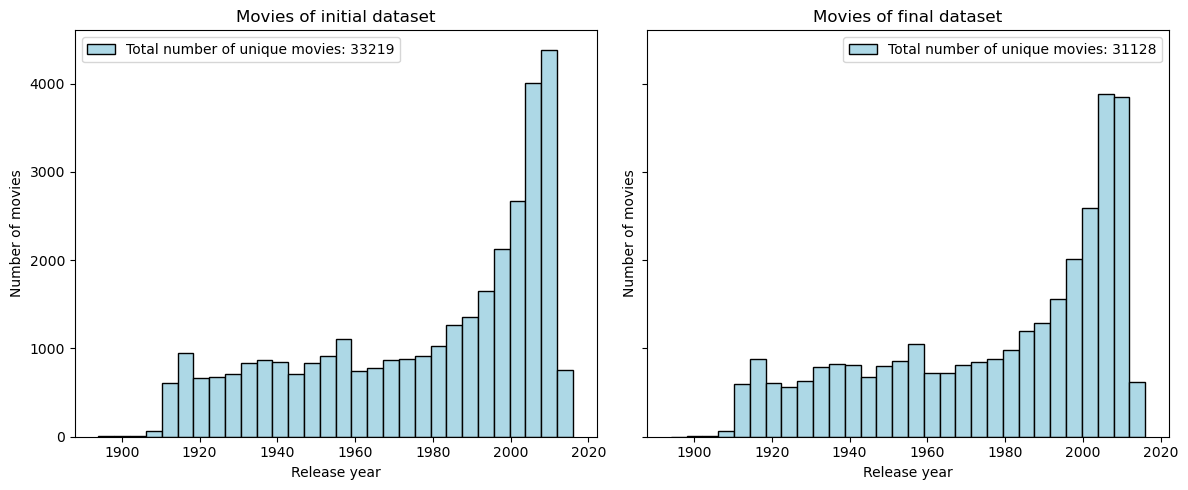

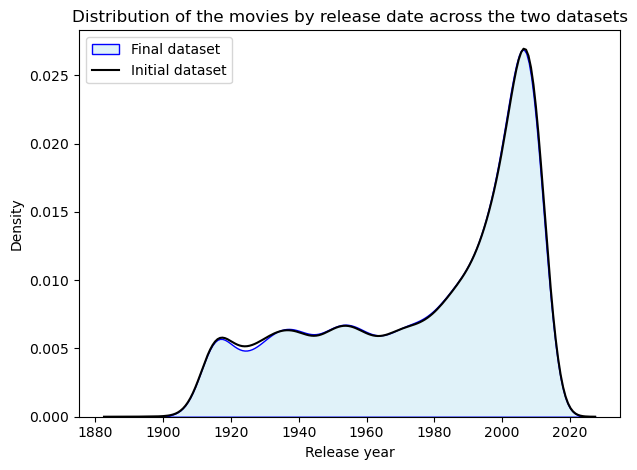

In [24]:
#count the number of unique movie containing the value of the subdataset  
final_df_movies = final_df.drop_duplicates(subset='Wikipedia_movie_ID') 
merged_df_movies = merged_df.dropna(subset=['Movie_release_date']).drop_duplicates(subset='Wikipedia_movie_ID') 
 
subdatasets = [(merged_df_movies, "Movies of initial dataset", len(merged_df_movies)), 
               (final_df_movies, "Movies of final dataset", len(final_df_movies))] 
 
#graph for the different number of movies per subdataset 
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True) 
for ax, (data, title, n) in zip(axes.flatten(), subdatasets): 
    ax.hist(data['Movie_release_date'], bins=30, color='lightblue', edgecolor='black', label=f'Total number of unique movies: {n}') 
    ax.set_title(title) 
    ax.set_xlabel("Release year") 
    ax.set_ylabel("Number of movies") 
    ax.legend() 
plt.tight_layout() 
plt.show() 
 
#graph for the different density of movies per subdataset 
sns.kdeplot(final_df_movies['Movie_release_date'].dropna(),fill=True,color='skyblue',edgecolor='blue', label="Final dataset") 
sns.kdeplot(merged_df_movies['Movie_release_date'].dropna(),color='black', label="Initial dataset") 
plt.title("Distribution of the movies by release date across the two datasets") 
plt.xlabel("Release year") 
plt.ylabel("Density") 
plt.legend() 
plt.tight_layout() 
plt.show()

This plot shows the distribution of the movies along time. We can observe that cleaning the dataset doesn't loose much data, and so our new dataset is still representatif of the initial data. And this is quite logical, as the moment when we lose a lot of data, is when we remove the movies without release date. But what shows the graph above is that all the other treatement we did on the data doesn't impact them. 

# 5.First plots

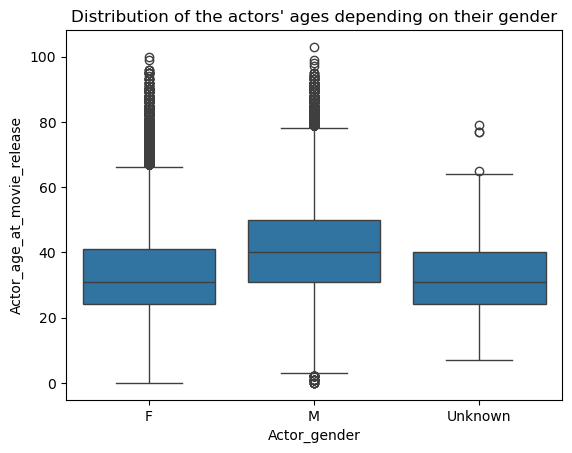

In [25]:
sns.boxplot(x=final_df["Actor_gender"], y=final_df["Actor_age_at_movie_release"], data=final_df.loc[final_df['Actor_gender'].isin(['M', 'F'])])
plt.title("Distribution of the actors' ages depending on their gender")
plt.show()

We can observe that the female actors seems to be younger that the males.

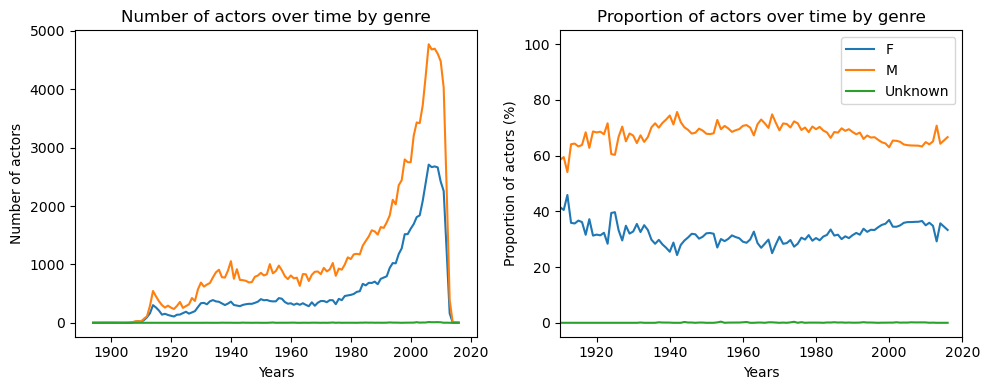

In [26]:
datafirstplot = final_df.groupby(["Movie_release_date","Actor_gender"]).Movie_release_date.count()
datafirstplot = pd.crosstab(final_df['Movie_release_date'],final_df['Actor_gender'])
datafirstplot_proportion = datafirstplot.div(datafirstplot.sum(axis=1), axis=0) * 100

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))
for column in datafirstplot.columns:
    ax1.plot(datafirstplot.index, datafirstplot[column], label=column)
    ax2.plot(datafirstplot_proportion.index, datafirstplot_proportion[column], label=column)
    
ax1.set_xlabel("Years")
ax1.set_ylabel("Number of actors")
ax1.set_title("Number of actors over time by genre")
ax2.set_xlabel("Years")
ax2.set_xlim(1910, 2020)
ax2.set_ylabel("Proportion of actors (%)")
ax2.set_title("Proportion of actors over time by genre")

plt.tight_layout()
plt.legend()
plt.show()